In [1]:
import sys
import os

import time
import numpy as np
import cvxpy as cp
from scipy.special import factorial, gamma
import matplotlib.pyplot as plt
from matplotlib.quiver import QuiverKey
import seaborn as sns

src_path = os.path.abspath('../src')
sys.path.append(src_path)

In [2]:
from prox import simplex_projection_1d
from grad import proximal_gradient_descent, nesterov_accelerated_gradient
from penalize_qpot import F
from utils import calculate_alpha, compute_mu_and_L

In [3]:
from matplotlib.ticker import AutoMinorLocator

plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 20
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 7.0
plt.rcParams["xtick.minor.size"] = 5.0
plt.rcParams["ytick.major.size"] = 7.0
plt.rcParams["ytick.minor.size"] = 5.0
plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams["legend.handlelength"] = 2.0
minor_locator = AutoMinorLocator(4)

$F_{\eta, \alpha}(\mathbf{X}) = \langle \mathbf{C}, \mathbf{X} \rangle  + \eta\|\mathbf{X}\|_2^2 + \alpha \sum^n_{i=1}\left[min(0, r_i - (\mathbf{X}1_n)_i)^2 + min(0, c_i - (\mathbf{X}^T1_n)_i)^2\right]$

In [4]:
X = np.array(
    [
        [1, 2, 3, 4, 5],
        [5, 4, 3, 2, 1],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [1, 1, 1, 1, 1],
    ]
)


# Define row and column constraints
r = np.array([15, 12, 5, 8, 0])  # Row constraints
c = np.array([10, 10, 10, 10, 10])  # Column constraints
# Define regularization parameter
alpha = 1.0#calculate_alpha(r, c, 1, 1e-6, eta, C)

# Step 1: Compute row and column sums
row_sums = np.sum(X, axis=1)  # Sum across rows (shape: n,)
col_sums = np.sum(X, axis=0)  # Sum across columns (shape: m,)

# Step 2: Identify active constraints for rows and columns
row_active = (
    r - row_sums
) < 0  # Boolean mask for row violations (shape: n,)
col_active = (
    c - col_sums
) < 0  # Boolean mask for column violations (shape: m,)

n = X.shape[0]
# Initialize gradient matrix
gradient = np.zeros_like(X, dtype=np.float64)

# Step 3: Compute row gradient contributions
row_grad_coeffs = -2 * alpha * (r - row_sums) * row_active
row_grad = np.zeros_like(X, dtype=np.float64)
for i in range(n):
    if row_active[i]:  # Only apply gradient if row constraint is violated
        gradient[i, :] += row_grad_coeffs[i]  # Add contribution to the row
        row_grad[i, :] = row_grad_coeffs[i]

# Step 4: Compute column gradient contributions
col_grad_coeffs = -2 * alpha * (c - col_sums) * col_active
col_grad = np.zeros_like(X, dtype=np.float64)
for j in range(X.shape[1]):
    if col_active[j]:  # Only apply gradient if column constraint is violated
        gradient[:, j] += col_grad_coeffs[j]  # Add contribution to the column
        col_grad[:, j] = col_grad_coeffs[j]

print("r:", r)
print("Row sums:", row_sums)
print("Row active mask:", row_active)
print("Row Gradient Coefficients:", row_grad_coeffs)
print("Row gradient contributions:", row_grad)
print("-----------------------------")

print("c:", c)
print("Column sums:", col_sums)
print("Column active mask:", col_active)
print("Column Gradient Coefficients:", col_grad_coeffs)
print("Column gradient contributions:", col_grad)
print("Gradient:", gradient)

# # Create an instance of P
# penalty = P(r, c, alpha)

# # Compute the gradient
# gradient = penalty.grad(X)

# Assertions to validate gradient correctness
# Check row-wise constraints
row_sums = np.sum(X, axis=1)
for i in range(X.shape[0]):
    print(f"Row {i}: r[i] = {r[i]}, row_sum = {row_sums[i]}, diff = {r[i] - row_sums[i]}")
    if r[i] - row_sums[i] < 0:  # Constraint violated
        expected_row_grad = -2 * alpha * (r[i] - row_sums[i])
        assert np.allclose(
            row_grad[i, :], expected_row_grad, atol=1e-8
        ), f"Row {i} row_grad incorrect. Expected {expected_row_grad}, got {row_grad[i, :].mean()}."
    else:  # Constraint satisfied, row gradient should be zero
        assert np.allclose(
            row_grad[i, :], 0, atol=1e-8
        ), f"Row {i} row_grad should be zero. Got {row_grad[i, :].mean()}."

# Check column-wise constraints
col_sums = np.sum(X, axis=0)
for j in range(X.shape[1]):
    print(f"Column {j}: c[j] = {c[j]}, col_sum = {col_sums[j]}, diff = {c[j] - col_sums[j]}")
    if c[j] - col_sums[j] < 0:  # Constraint violated
        expected_col_grad = -2 * alpha * (c[j] - col_sums[j])
        assert np.allclose(
            col_grad[:, j], expected_col_grad, atol=1e-8
        ), f"Column {j} col_grad incorrect. Expected {expected_col_grad}, got {col_grad[:, j].mean()}."
    else:  # Constraint satisfied, column gradient should be zero
        assert np.allclose(
            col_grad[:, j], 0, atol=1e-8
        ), f"Column {j} col_grad should be zero. Got {col_grad[:, j].mean()}."

# Test 1: Check if gradient is non-zero only for active constraints
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        is_active = row_active[i] or col_active[j]  # Either row or column is active
        if is_active:
            assert not np.allclose(gradient[i, j], 0, atol=1e-8), (
                f"Gradient at ({i}, {j}) should be non-zero, but got {gradient[i, j]}"
            )
        else:
            assert np.allclose(gradient[i, j], 0, atol=1e-8), (
                f"Gradient at ({i}, {j}) should be zero, but got {gradient[i, j]}"
            )

# Print results
print("Input matrix X:")
print(X)
print("\nGradient of P(X, alpha):")
print(gradient)
print("\nAll gradient assertions passed!")

r: [15 12  5  8  0]
Row sums: [15 15  5 10  5]
Row active mask: [False  True False  True  True]
Row Gradient Coefficients: [-0.  6. -0.  4. 10.]
Row gradient contributions: [[ 0.  0.  0.  0.  0.]
 [ 6.  6.  6.  6.  6.]
 [ 0.  0.  0.  0.  0.]
 [ 4.  4.  4.  4.  4.]
 [10. 10. 10. 10. 10.]]
-----------------------------
c: [10 10 10 10 10]
Column sums: [10 10 10 10 10]
Column active mask: [False False False False False]
Column Gradient Coefficients: [-0. -0. -0. -0. -0.]
Column gradient contributions: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Gradient: [[ 0.  0.  0.  0.  0.]
 [ 6.  6.  6.  6.  6.]
 [ 0.  0.  0.  0.  0.]
 [ 4.  4.  4.  4.  4.]
 [10. 10. 10. 10. 10.]]
Row 0: r[i] = 15, row_sum = 15, diff = 0
Row 1: r[i] = 12, row_sum = 15, diff = -3
Row 2: r[i] = 5, row_sum = 5, diff = 0
Row 3: r[i] = 8, row_sum = 10, diff = -2
Row 4: r[i] = 0, row_sum = 5, diff = -5
Column 0: c[j] = 10, col_sum = 10, diff = 0
Column 1: c[j] = 10, col_sum = 1

### Test implementation of the original problem turned penalized

#### Set up the experiment

In [5]:
def measure_sparsity(solution_matrix, threshold=1e-10):
    """
    Hàm này đo lường sparsity của một ma trận, xem xét các phần tử có giá trị tuyệt đối
    nhỏ hơn ngưỡng đã chỉ định là bằng 0.

    Sparsity được định nghĩa là tỷ lệ các phần tử được xem là bằng 0 trong ma trận.

    Tham số:
    solution_matrix (np.ndarray): Ma trận cần đo lường sparsity.
    threshold (float): Ngưỡng dưới đó các phần tử được coi là bằng 0 (mặc định là 1e-10).

    Trả về:
    float: Độ sparsity của ma trận, dưới dạng giá trị từ 0 đến 1.
    """
    # Đếm số lượng phần tử được coi là bằng 0 (nhỏ hơn ngưỡng)
    zero_elements = np.sum(np.abs(solution_matrix) < threshold)

    # Tính tổng số phần tử trong ma trận
    total_elements = solution_matrix.size

    # Tính độ sparsity dưới dạng tỷ lệ của các phần tử được coi là bằng 0
    sparsity = zero_elements / total_elements

    return sparsity


def round_heatmap(method_matrices, epsilon, threshold=1e-10):
    """
    Plots heatmaps for the provided method matrices (solutions) and includes epsilon in the plot title.

    :param threshold: The threshold value to discretize the solution matrices.
    :param epsilon: The epsilon value to display in the plot title.
    :param method_matrices: A dictionary where keys are method names and values are the corresponding solution matrices.
    """
    # Discretize all input matrices (round them based on threshold)
    rounded_matrices = {
        method: np.where(np.abs(matrix) < threshold, 0, 1)
        for method, matrix in method_matrices.items()
    }

    num_matrices = len(rounded_matrices)
    max_columns = 3  # Maximum 3 matrices per row
    columns = min(num_matrices, max_columns)  # Adjust columns dynamically
    rows = (
        num_matrices + columns - 1
    ) // columns  # Calculate the number of rows needed

    # Adjust figsize based on the number of plots
    scale = 6
    if num_matrices == 1:
        scale = 10
    elif num_matrices == 2:
        scale = 8

    plt.rcParams["font.family"] = "serif"
    fig, axes = plt.subplots(rows, columns, figsize=(scale * columns, scale * rows))
    axes = (
        axes.flatten() if num_matrices > 1 else [axes]
    )  # Flatten axes for consistency

    for idx, (method_name, rounded_matrix) in enumerate(rounded_matrices.items()):
        ax = axes[idx]

        # Draw the heatmap for each method
        sns.heatmap(
            rounded_matrix,
            cmap=sns.color_palette(["white", "red"], as_cmap=True),
            ax=ax,
            cbar=False,
        )

        # Set title and format the plot
        ax.set_title(
            f"Transport Plan {method_name}\nEpsilon: {epsilon}, Sparsity: {np.round(measure_sparsity(rounded_matrix), 4)}",
            fontsize=16,
        )
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks

        # Add a box around the heatmap
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(1.5)
            spine.set_color("black")

    # If there are unused axes, hide them
    for idx in range(len(rounded_matrices), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
def visualize_trajectory_contour(f, history, span=30):
    """
    Visualize the trajectory of gradient descent on a contour plot of f(X).

    Args:
        f (f): An instance of the f(X) class.
        history (list): List of flattened X arrays during optimization.
    """
    # Convert history to a numpy array
    history_flat = np.array(history)  # Ensure history is a list of flattened X arrays

    # Automatically determine plot range based on the trajectory
    x_min, x_max = np.min(history_flat[:, 0]) - span, np.max(history_flat[:, 0]) + span
    y_min, y_max = np.min(history_flat[:, 1]) - span, np.max(history_flat[:, 1]) + span

    # Create a grid for contour plotting
    x = np.linspace(x_min, x_max, 300)
    y = np.linspace(y_min, y_max, 300)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Compute f(X) values for visualization
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Construct a matrix with the same shape as f.C
            input_matrix = np.zeros_like(f.C)
            input_matrix[0, 0] = X[i, j]  # Set values based on the grid
            input_matrix[1, 1] = Y[i, j]
            Z[i, j] = f(input_matrix)  # Compute f(X)

    # Plot the contours
    plt.figure(figsize=(10, 8))
    contour = plt.contour(X, Y, Z, levels=50, cmap="viridis")
    plt.colorbar(contour)

    # Overlay the trajectory
    plt.plot(
        history_flat[:, 0],
        history_flat[:, 1],
        "-o",
        color="red",
        label="Trajectory",
        markersize=4,
    )
    plt.scatter(
        history_flat[0, 0],
        history_flat[0, 1],
        color="blue",
        label="Start (X_init)",
        zorder=5,
        s=50,
    )
    plt.scatter(
        history_flat[-1, 0],
        history_flat[-1, 1],
        color="green",
        label="End (X_opt)",
        zorder=5,
        s=50,
    )

    # Labels and legend
    plt.xlabel("X[0]")
    plt.ylabel("X[1]")
    plt.title("Gradient Descent Trajectory on Contour Plot of f(X)")
    plt.legend()
    plt.grid()
    plt.show()


def visualize_trajectory_3D(f, history, span=30):
    """
    Visualize the trajectory of gradient descent on an expanded 3D surface plot of f(X).

    Args:
        f (f): An instance of the f(X) class.
        history (list): List of flattened X arrays during optimization.
    """
    # Convert history to a numpy array
    history_flat = np.array(history)  # Ensure history is a list of flattened X arrays

    # Automatically determine plot range based on the trajectory
    x_min, x_max = np.min(history_flat[:, 0]) - span, np.max(history_flat[:, 0]) + span
    y_min, y_max = np.min(history_flat[:, 1]) - span, np.max(history_flat[:, 1]) + span

    # Create a grid for surface plotting
    x = np.linspace(x_min, x_max, 100)
    y = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Compute f(X) values for visualization
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Initialize input_matrix with zeros and the same shape as f.C
            input_matrix = np.zeros_like(f.C)

            # Populate input_matrix with grid values
            # For simplicity, assign X[i, j] and Y[i, j] to the first two entries
            input_matrix[0, 0] = X[i, j]
            input_matrix[0, 1] = Y[i, j]

            # Evaluate f(X) with the constructed input_matrix
            Z[i, j] = f(input_matrix)

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.8)

    # Compute trajectory z-coordinates
    trajectory_z = []
    for x in history_flat:
        # Reshape flattened X back to its original shape (f.C.shape)
        reshaped_x = x.reshape(f.C.shape)
        trajectory_z.append(f(reshaped_x))

    # Overlay the trajectory
    ax.plot(
        history_flat[:, 0],
        history_flat[:, 1],
        trajectory_z,
        color="red",
        label="Trajectory",
        linewidth=2,
    )

    # Mark start and end points
    ax.scatter(
        history_flat[0, 0],
        history_flat[0, 1],
        trajectory_z[0],
        color="blue",
        label="Start (X_init)",
        s=50,
    )
    ax.scatter(
        history_flat[-1, 0],
        history_flat[-1, 1],
        trajectory_z[-1],
        color="green",
        label="End (X_opt)",
        s=50,
    )

    # Set axis limits and labels
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(np.min(Z), np.max(Z))  # Adjust z-axis limits dynamically
    ax.set_xlabel("X[0]")
    ax.set_ylabel("X[1]")
    ax.set_zlabel("f(X)")
    ax.set_title("Gradient Descent Trajectory on 3D Surface of f(X)")
    ax.legend()

    plt.show()

In [7]:
# Hàm tạo phân phối Mixed Gaussian
def generate_mixed_gaussian(n_samples, n_bins, mu1, sigma1, mu2, sigma2):
    bernoulli = np.random.binomial(n=1, p=0.5, size=n_samples)
    gaussian1 = np.random.normal(mu1, sigma1, n_samples)
    gaussian2 = np.random.normal(mu2, sigma2, n_samples)
    dist = gaussian1 * bernoulli + gaussian2 * (1 - bernoulli)

    x = np.linspace(min(dist), max(dist), n_samples)
    p, edges = np.histogram(dist, bins=n_bins, density=True)

    pdf = 0.5 * (
        1 / (sigma1 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
    ) + 0.5 * (
        1 / (sigma2 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)
    )

    return dist, p, edges, x, pdf


# Hàm tạo phân phối Gamma
def generate_gamma(n_samples, n_bins, shape, scale):
    dist = np.random.gamma(shape, scale, n_samples)

    x = np.linspace(min(dist), max(dist), n_samples)
    p, edges = np.histogram(dist, bins=n_bins, density=True)

    pdf = (x ** (shape - 1) * np.exp(-x / scale)) / (scale**shape * gamma(shape))

    return dist, p, edges, x, pdf

In [8]:
n_bins = 100
n_samples = 100000
mu1, sigma1 = 1, 2
mu2, sigma2 = 10, 1.5

dist_a, p_a, edges_a, x_a, pdf_a = generate_mixed_gaussian(
    n_samples, n_bins, mu1, sigma1, mu2, sigma2
)

shape_b, scale_b = 7, 1
dist_b, p_b, edges_b, x_b, pdf_b = generate_gamma(
    n_samples, n_bins, shape_b, scale_b
)

# Normalize distributions
r = (p_a + 1e-6)/ np.sum(p_a)
c = (p_b + 1e-6) / np.sum(p_b)
s = 0.8 * min(r.sum(), c.sum())

# Compute cost matrix using L2 norm
C = (edges_a[:-1].reshape(-1, 1) - edges_b[:-1].reshape(1, -1)) ** 2
C = C / np.max(C)

X_init = np.full(C.shape, 0.1)
#X_init = X_init / np.sum(X_init)
X_init, X_init.sum()

(array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        ...,
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]]),
 1000.0000000000002)

In [9]:
# Regularization parameters
eta = 0.01
s = 0.6
eps_tol = 1e-6
alpha = calculate_alpha(r, c, s, eps_tol, eta, C)
print("Optimal alpha =", alpha)

# Define the combined objective function
F_obj = F(C, eta, r, c, alpha, s)

Optimal alpha = 17530735351866.258


#### Test Proximal Gradient Descent

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Iteration |Objective Value          |f_eta(X)    | P(X, alpha)           |Sum(X)    |Validation                    
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1         |11067983738636.390625    | 0.012054   | 11067983738636.378906 |0.6000    |FAIL: Row failed with max difference: 0.5675 Column failed with max difference: 0.55614
2         |41802089457.811745       | 0.059165   | 41802089457.752579    |0.6000    |FAIL: Row failed with max difference: 0.00747 Column failed with max difference: 0.00735
3         |9959911880.890987        | 0.017469   | 9959911880.873518     |0.6000    |FAIL: Row failed with max difference: 0.0063 Column failed with 

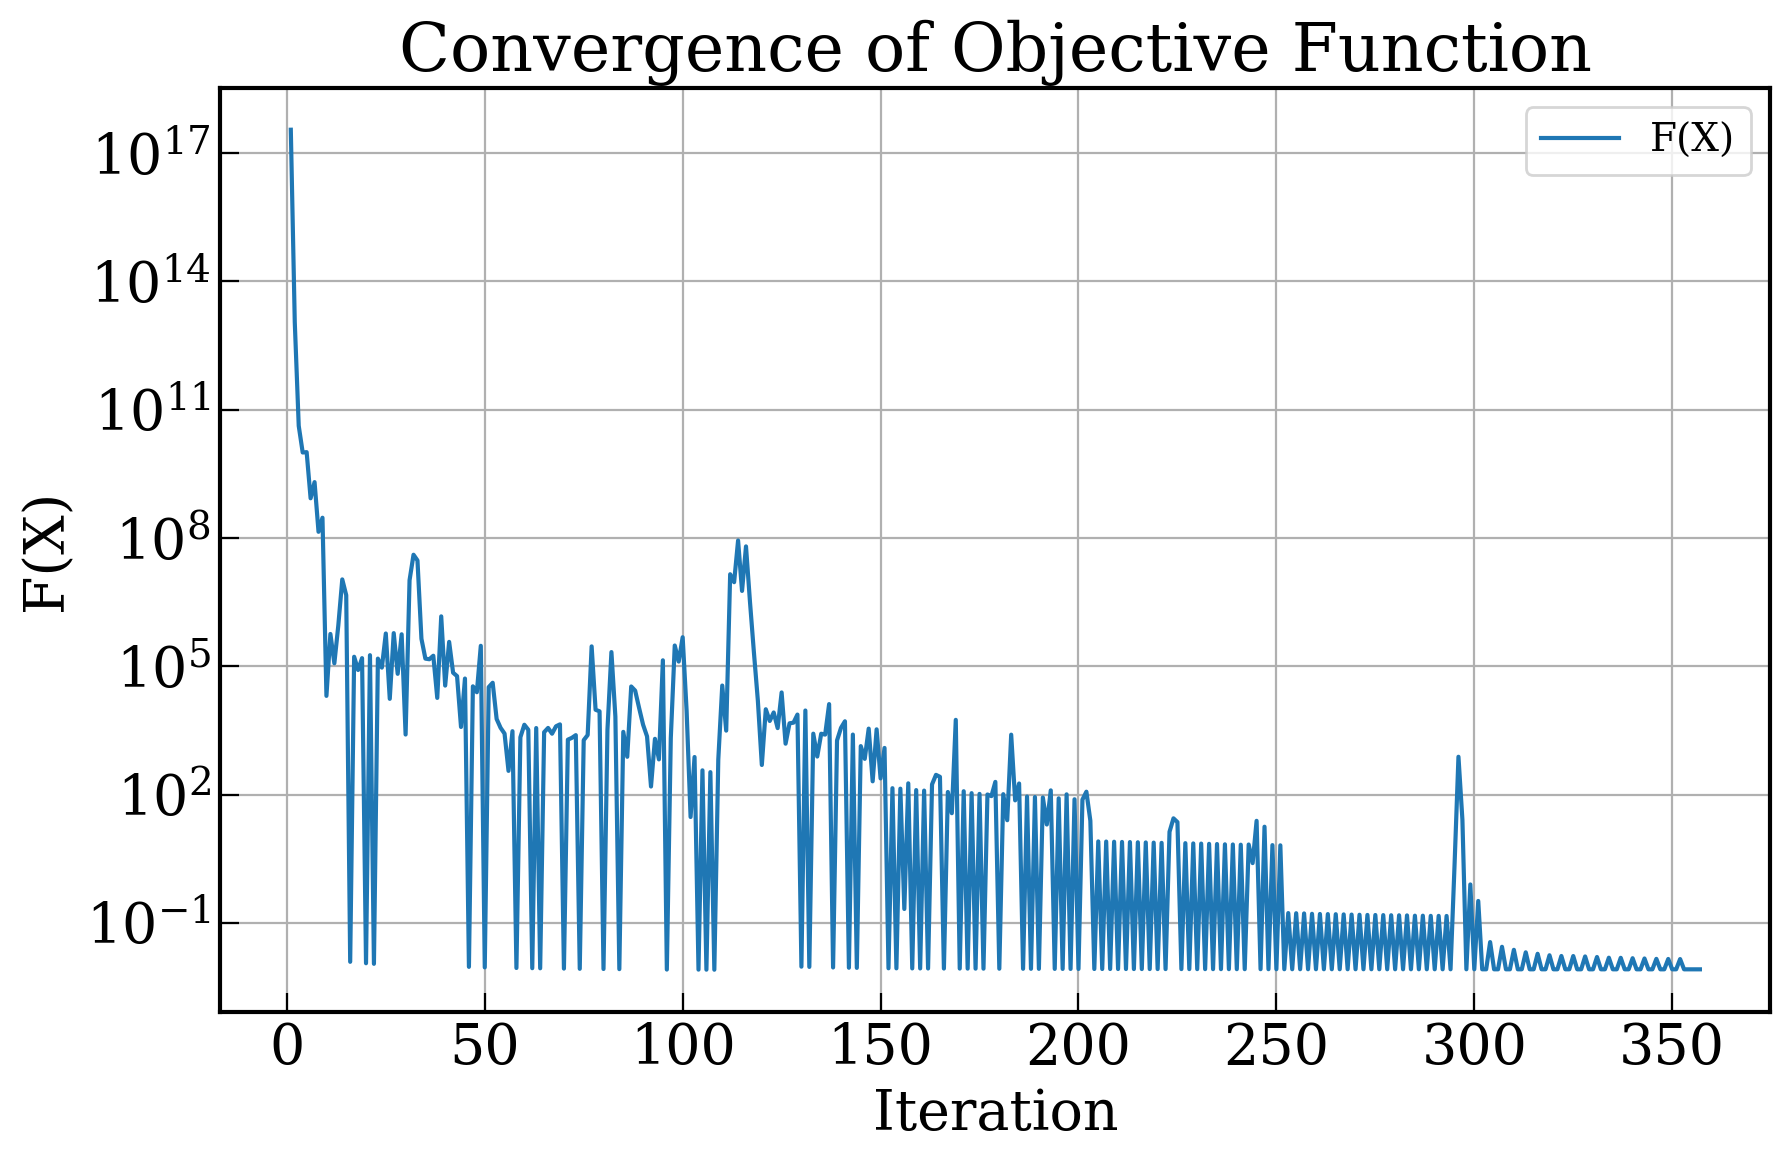

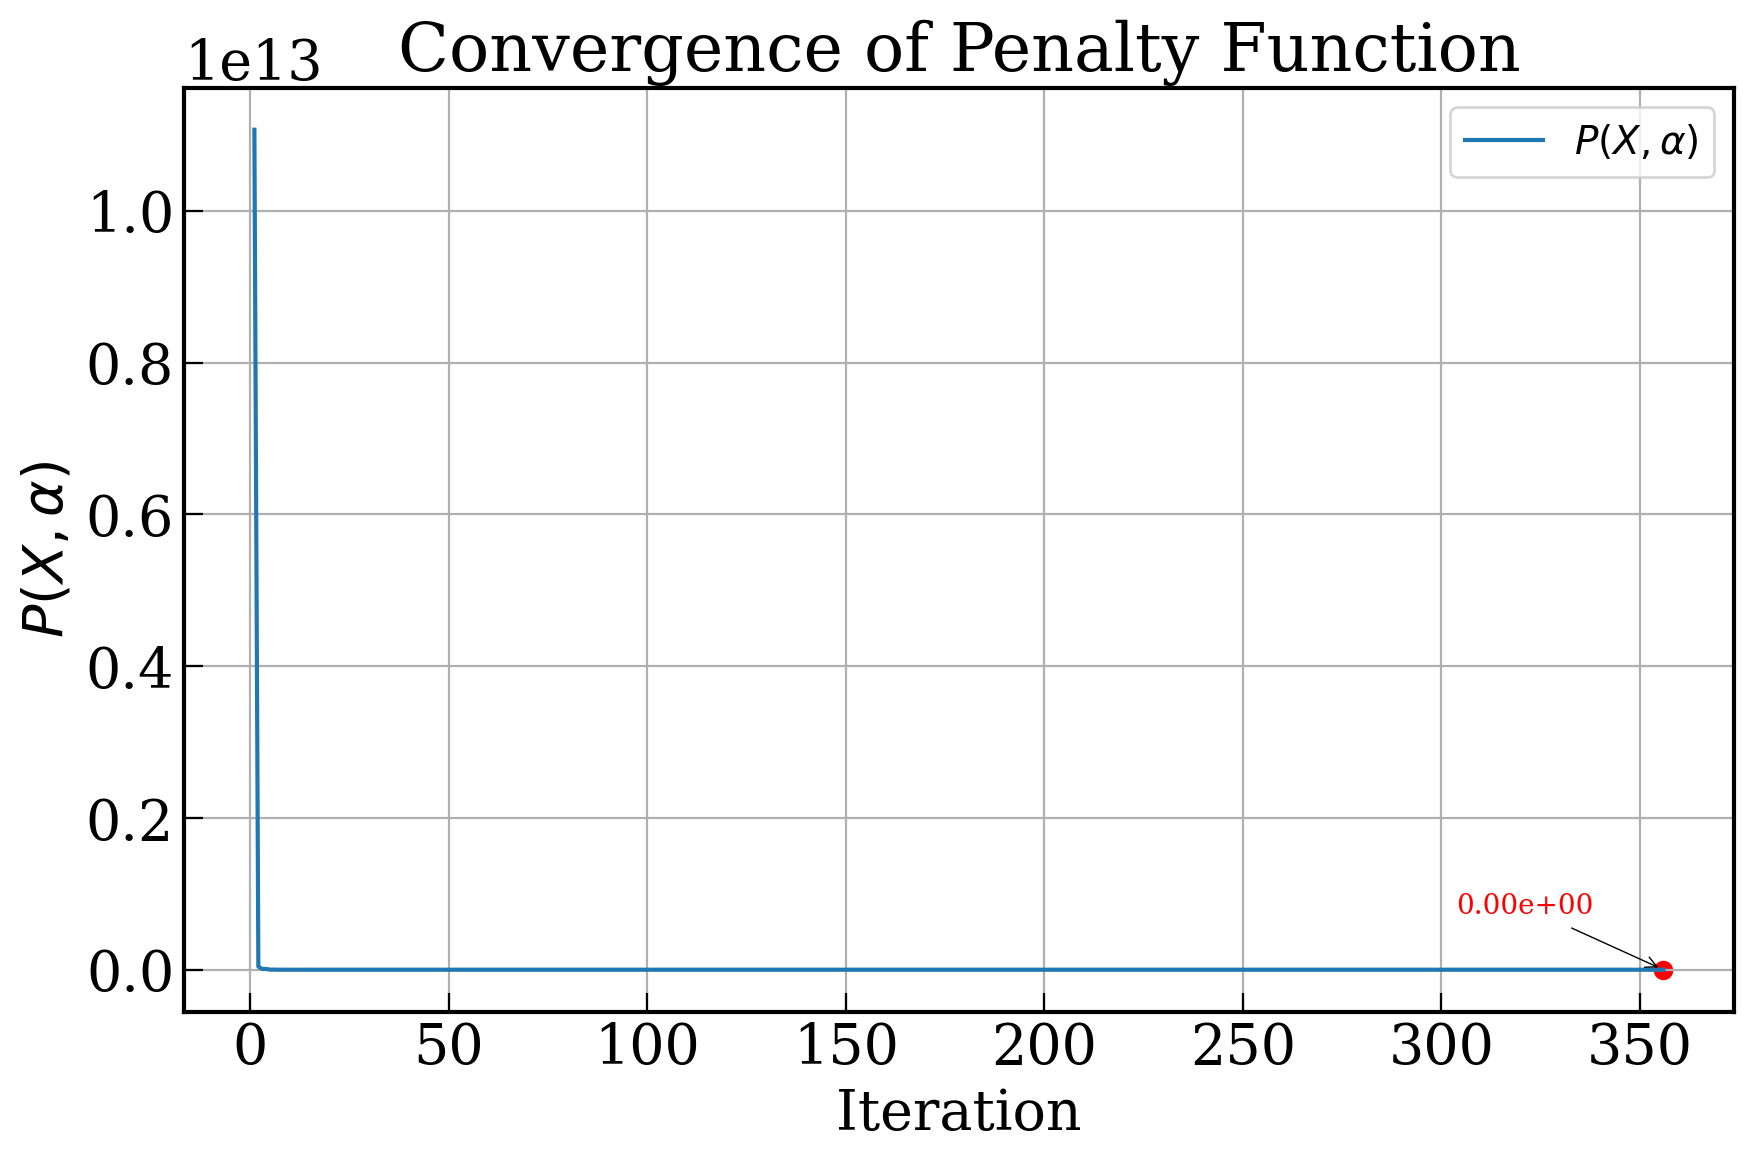

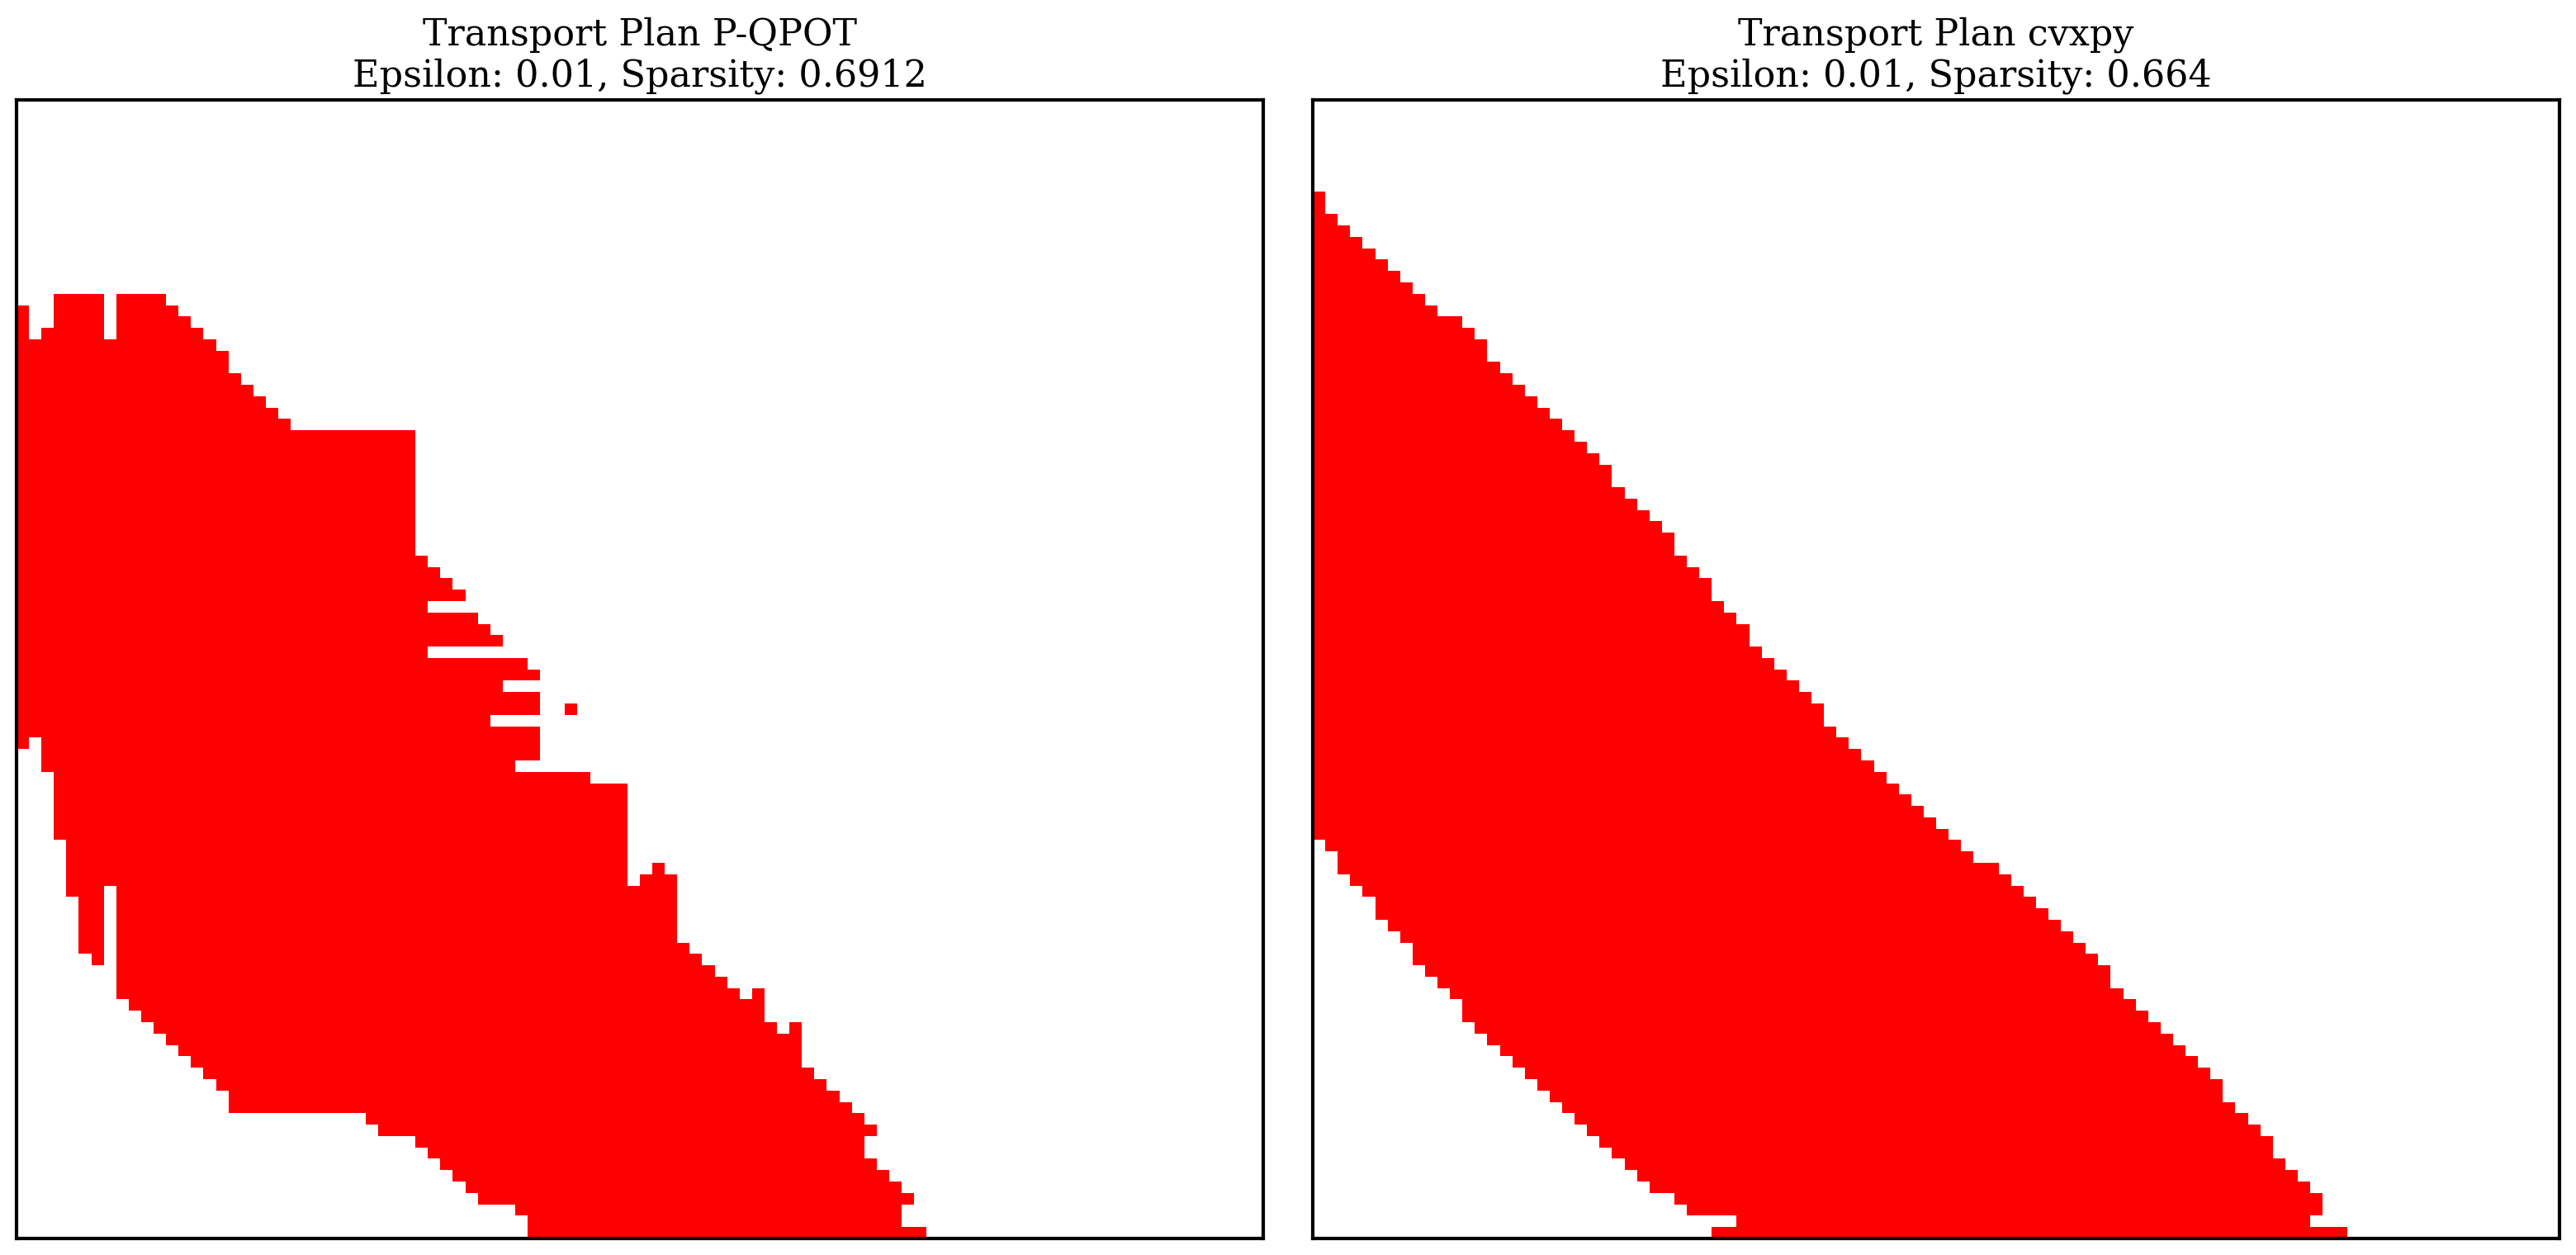

P-QPOT Final cost: 0.000033, Sparsity: 0.6912, Runtime: 0.2840232849121094
CVXPY Final cost: 0.000245, Sparsity: 0.664000, Runtime: 0.3850717544555664


In [10]:
start_time = time.time()
# Run proximal gradient descent
X_opt, history, objective_history, penalty_history = proximal_gradient_descent(
    F_obj,
    X_init, 
    lr=3e-4, 
    max_iter=1000, 
    tol=1e-6, 
    decay_rate=0.6, 
    step=50, 
    eps_tol=eps_tol,
    early_stop=True, 
    verbose=True)

p_qpot_runtime = time.time() - start_time
# Plot the convergence
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, len(objective_history) + 1)), objective_history, label="F(X)")
plt.xlabel("Iteration")
plt.ylabel("F(X)")
plt.yscale('log')
plt.title("Convergence of Objective Function")
plt.legend()
plt.grid()
plt.show()

# Plot the convergence of only the penalty term
plt.figure(figsize=(10, 6))
iterations = list(range(1, len(penalty_history) + 1))
final_value_x = iterations[-1]
final_value_y = penalty_history[-1]
plt.plot(iterations, penalty_history, label=r"$P(X, \alpha)$")
plt.xlabel("Iteration")
plt.ylabel(r"$P(X, \alpha)$")
plt.title("Convergence of Penalty Function")
plt.legend()
plt.scatter(final_value_x, final_value_y, color="red", label="Final Value")
plt.annotate(
    f"{final_value_y:.2e}",
    (final_value_x, final_value_y),
    textcoords="offset points",
    xytext=(-50, 20),  # Adjusting to ensure proper visibility
    ha="center",
    color="red",
    fontsize=10,
    arrowprops=dict(facecolor="red", arrowstyle="->", lw=0.5),
)
plt.grid()
plt.show()

######################################################################################################
# Khai báo biến kế hoạch vận chuyển
X_cp = cp.Variable(C.shape, nonneg=True)

# Định nghĩa các ràng buộc cho bài toán POT
constraints = [
    cp.sum(X_cp, axis=1) <= r.reshape(-1, 1).flatten(),
    cp.sum(X_cp, axis=0) <= c.reshape(-1, 1).flatten(),
    cp.sum(X_cp) == s,
]

# Định nghĩa hàm mục tiêu với regularization quadratic
objective = cp.Minimize(cp.trace(C.T @ X_cp) + (0.01 / 2) * cp.norm(X_cp, "fro") ** 2)

######################################################################################################
# Định nghĩa và giải bài toán
start_time = time.time()
prob = cp.Problem(objective, constraints)
prob.solve()
qpot_runtime = time.time() - start_time
round_heatmap({"P-QPOT": X_opt, "cvxpy": X_cp.value}, 0.01)

print(f"P-QPOT Final cost: {(np.trace(np.multiply(C, X_opt))+eta*np.sum(X_opt**2)):.6f}, Sparsity: {measure_sparsity(X_opt):.4f}, Runtime: {p_qpot_runtime}")
print(
    f"CVXPY Final cost: {prob.value:.6f}, Sparsity: {measure_sparsity(X_cp.value):.6f}, Runtime: {qpot_runtime}"
)

In [11]:
row_sums = np.sum(X_opt, axis=1)
col_sums = np.sum(X_opt, axis=0)
# Compare row_sums with r
row_exceeds = row_sums > r
row_exceed_indices = np.where(row_exceeds)[0]  # Indices where row_sums exceeds r

# Compare col_sums with c
col_exceeds = col_sums > c
col_exceed_indices = np.where(col_exceeds)[0]  # Indices where col_sums exceeds c

# Print results
print("Indices where row_sums exceeds r:", row_exceed_indices)
print("Values of row_sums that exceed r:", row_sums[row_exceed_indices])
print("Indices where col_sums exceeds c:", col_exceed_indices)
print("Values of col_sums that exceed c:", col_sums[col_exceed_indices])

Indices where row_sums exceeds r: []
Values of row_sums that exceed r: []
Indices where col_sums exceeds c: []
Values of col_sums that exceed c: []


#### Test Nesterov's Method

In [12]:
mu, L = compute_mu_and_L(F_obj)
mu, L, mu / L, 1 / (1 - np.sqrt(mu / L))

(0.01, 1753073535186625.8, 5.704267276463926e-18, 1.0000000023883608)

-------------------------------------------------------------------------------------------------------------------------------------------------------
Iteration |Objective Value          |f_eta(X)    | P(X, alpha)           |Sum(X)    |Validation                    
-------------------------------------------------------------------------------------------------------------------------------------------------------
1         |1299287977.265587        | 0.016393   | 1299287977.249194     |0.6000    |FAIL: Row failed with max difference: 0.00178 Col passed
2         |1129036115.720777        | 0.011966   | 1129036115.708811     |0.6000    |FAIL: Row failed with max difference: 0.00024 Column failed with max difference: 0.00661
3         |985311935.846798         | 0.010826   | 985311935.835972      |0.6000    |FAIL: Row passed, Column failed with max difference: 0.00486
4         |309427292.249709         | 0.019776   | 309427292.229932      |0.6000    |FAIL: Row failed with max differe

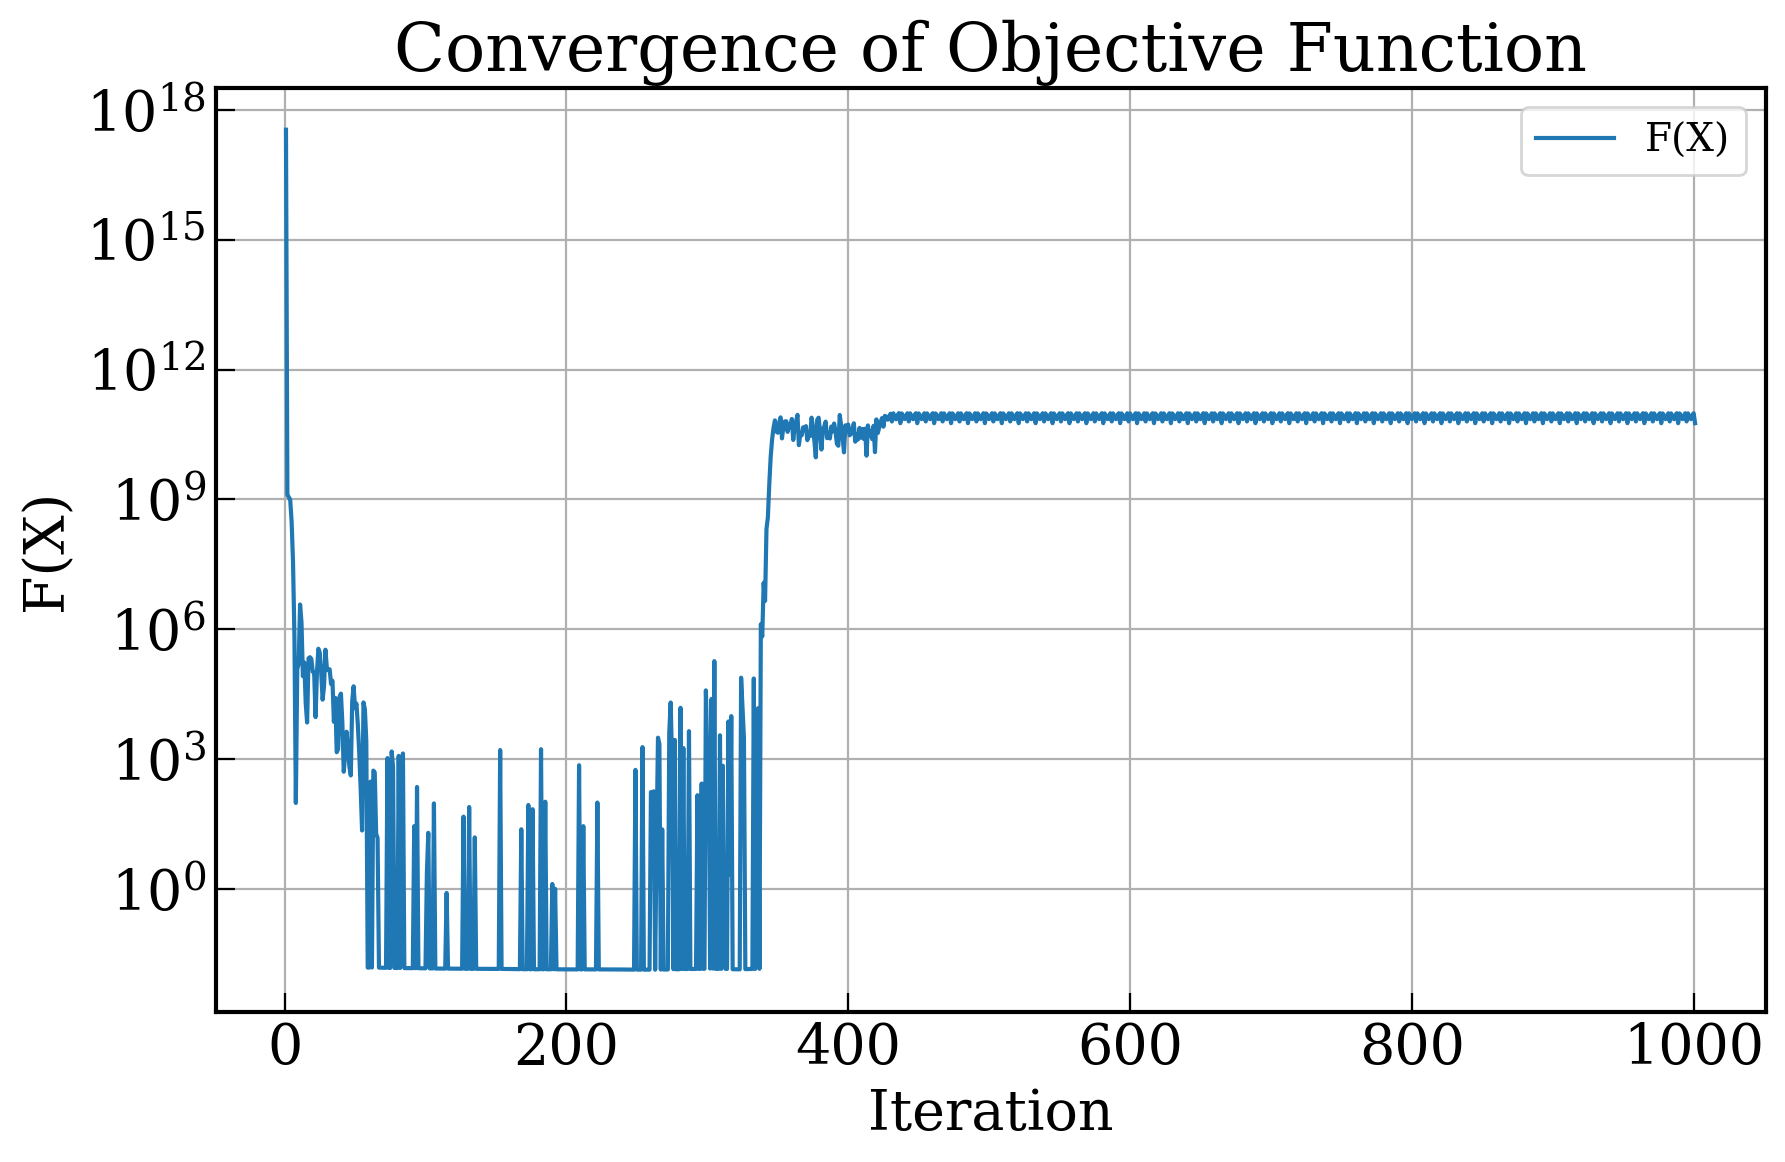

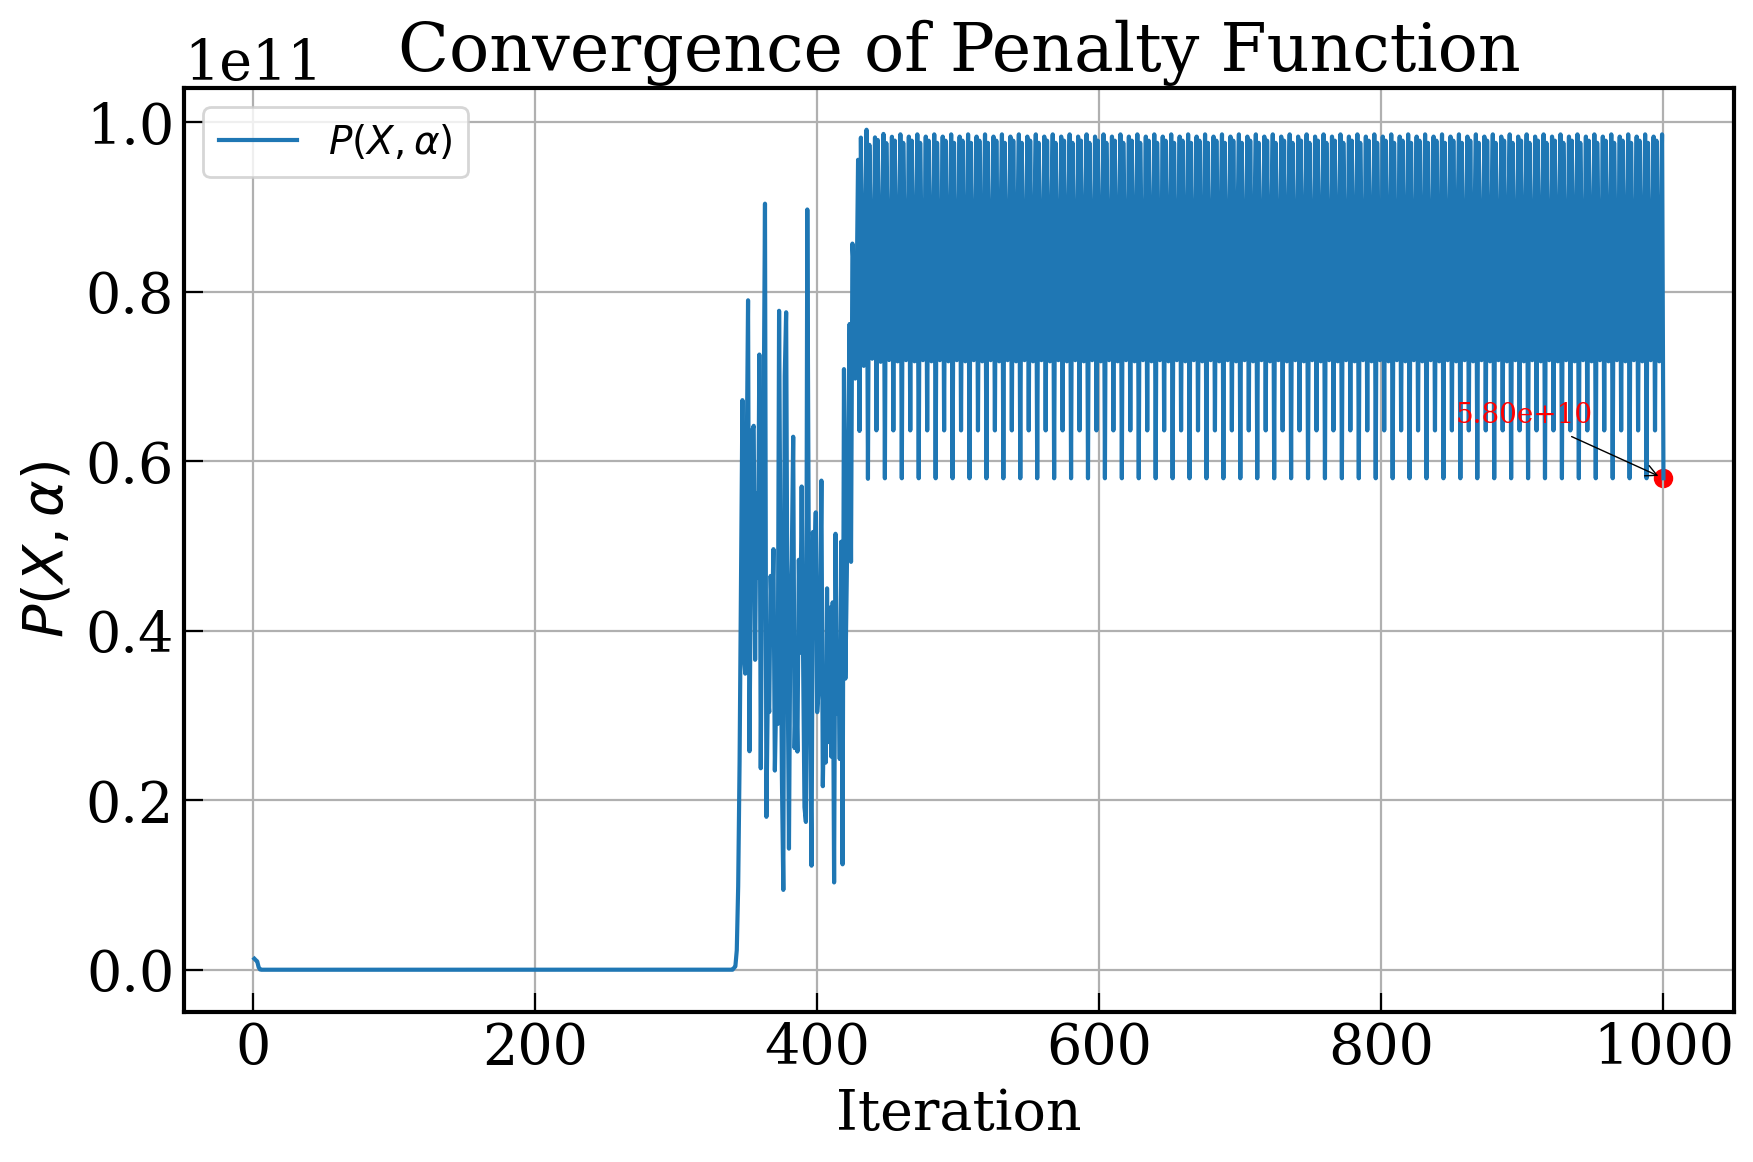

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1001,)

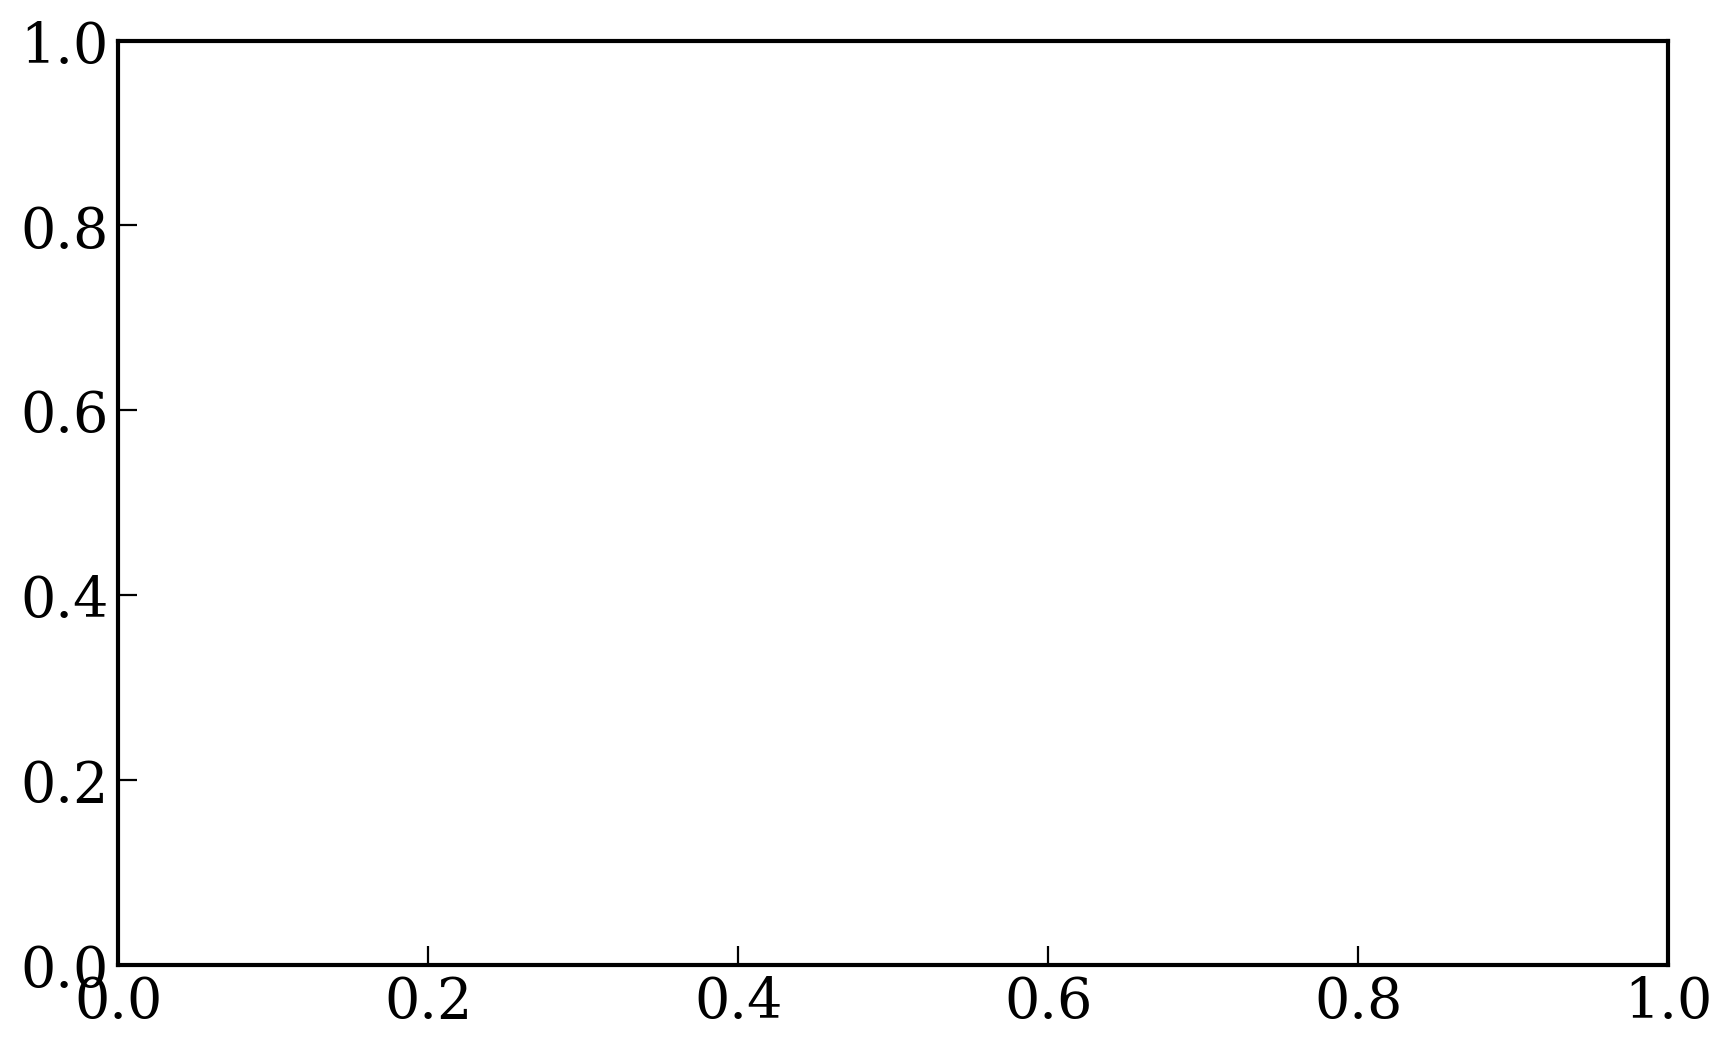

In [13]:
start_time = time.time()
# Run proximal gradient descent
X_opt, history, objective_history, penalty_history, A_history = nesterov_accelerated_gradient(
    F_obj,
    X_init,
    max_iter=1000,
    tol=1e-6,
    eps_tol=eps_tol,
    verbose=True,
    early_stop=True,
    line_search=False
)

p_qpot_runtime = time.time() - start_time
# Plot the convergence
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, len(objective_history) + 1)), objective_history, label="F(X)")
plt.xlabel("Iteration")
plt.ylabel("F(X)")
plt.yscale("log")
plt.title("Convergence of Objective Function")
plt.legend()
plt.grid()
plt.show()

# Plot the convergence of only the penalty term
plt.figure(figsize=(10, 6))
iterations = list(range(1, len(penalty_history) + 1))
final_value_x = iterations[-1]
final_value_y = penalty_history[-1]
plt.plot(iterations, penalty_history, label=r"$P(X, \alpha)$")
plt.xlabel("Iteration")
plt.ylabel(r"$P(X, \alpha)$")
plt.title("Convergence of Penalty Function")
plt.legend()
plt.scatter(final_value_x, final_value_y, color="red", label="Final Value")
plt.annotate(
    f"{final_value_y:.2e}",
    (final_value_x, final_value_y),
    textcoords="offset points",
    xytext=(-50, 20),  # Adjusting to ensure proper visibility
    ha="center",
    color="red",
    fontsize=10,
    arrowprops=dict(facecolor="red", arrowstyle="->", lw=0.5),
)
plt.grid()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(list(range(1, len(objective_history))), A_history, label="F(X)")
plt.xlabel("Iteration")
plt.ylabel("A")
plt.yscale("log")
plt.title("Convergence of A")
plt.legend()
plt.grid()
plt.show()

######################################################################################################
# Khai báo biến kế hoạch vận chuyển
X_cp = cp.Variable(C.shape, nonneg=True)

# Định nghĩa các ràng buộc cho bài toán POT
constraints = [
    cp.sum(X_cp, axis=1) <= r.reshape(-1, 1).flatten(),
    cp.sum(X_cp, axis=0) <= c.reshape(-1, 1).flatten(),
    cp.sum(X_cp) == s,
]

# Định nghĩa hàm mục tiêu với regularization quadratic
objective = cp.Minimize(cp.trace(C.T @ X_cp) + (0.01 / 2) * cp.norm(X_cp, "fro") ** 2)

######################################################################################################
# Định nghĩa và giải bài toán
start_time = time.time()
prob = cp.Problem(objective, constraints)
prob.solve()
qpot_runtime = time.time() - start_time
round_heatmap({"P-QPOT": X_opt, "cvxpy": X_cp.value}, 0.01)

print(
    f"P-QPOT Final cost: {(np.trace(np.multiply(C, X_opt))+eta*np.sum(X_opt**2)):.6f}, Sparsity: {measure_sparsity(X_opt):.4f}, Runtime: {p_qpot_runtime}"
)
print(
    f"CVXPY Final cost: {prob.value:.6f}, Sparsity: {measure_sparsity(X_cp.value):.6f}, Runtime: {qpot_runtime}"
)